# Every Person Is Different

Each person is different. 

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")
tax_df = cf_analysis_lib.read_taxonomy(datadir, sequence_type, "family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


### Choose people with longitudinal sampling

In [2]:
interesting_people = list(map(str, metadata.groupby(by='pwCF_ID').count().sort_values(by='MGI', ascending=False).index[0:6]))
interesting_people

['788707', '825012', '676138', '785991', '748699', '658355']

# Fig 2a. The taxonomy of individual pwCF over time

In [3]:
# We need to filter on the total number of normalized reads.
# This is a somewhat empirical and lazy way to figure out which minrow sum we should apply below. But it works!
for minrowsum in [1000, 1500, 2000, 2500, 5000, 10000]:
    # figure out the common bacteria
    all_bacteria = dict()
    for i, pwCF_ID in enumerate(interesting_people):
        pta = [x for x in tax_df.columns if x.startswith(pwCF_ID)]
        pta_df = tax_df[pta]
        pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]
        all_bacteria.update({x:x.replace(f"{taxa[0]}__", "").replace(" Family ", "_").replace("Candidatus ", "").split(" ")[0] for x in pta_df.index.unique()})
        
    bacteria_name = dict(sorted(all_bacteria.items(), key=lambda item: item[1], reverse=True))
    bacteria_list = list(bacteria_name.keys())
    print(f"Min row sum: {minrowsum} Number of bacteria: {len(bacteria_list)}")

Min row sum: 1000 Number of bacteria: 78
Min row sum: 1500 Number of bacteria: 68
Min row sum: 2000 Number of bacteria: 61
Min row sum: 2500 Number of bacteria: 52
Min row sum: 5000 Number of bacteria: 41
Min row sum: 10000 Number of bacteria: 32


i) pwCF 788707; ii) pwCF 825012; iii) pwCF 676138; iv) pwCF 785991; v) pwCF 748699; vi) pwCF 658355; 


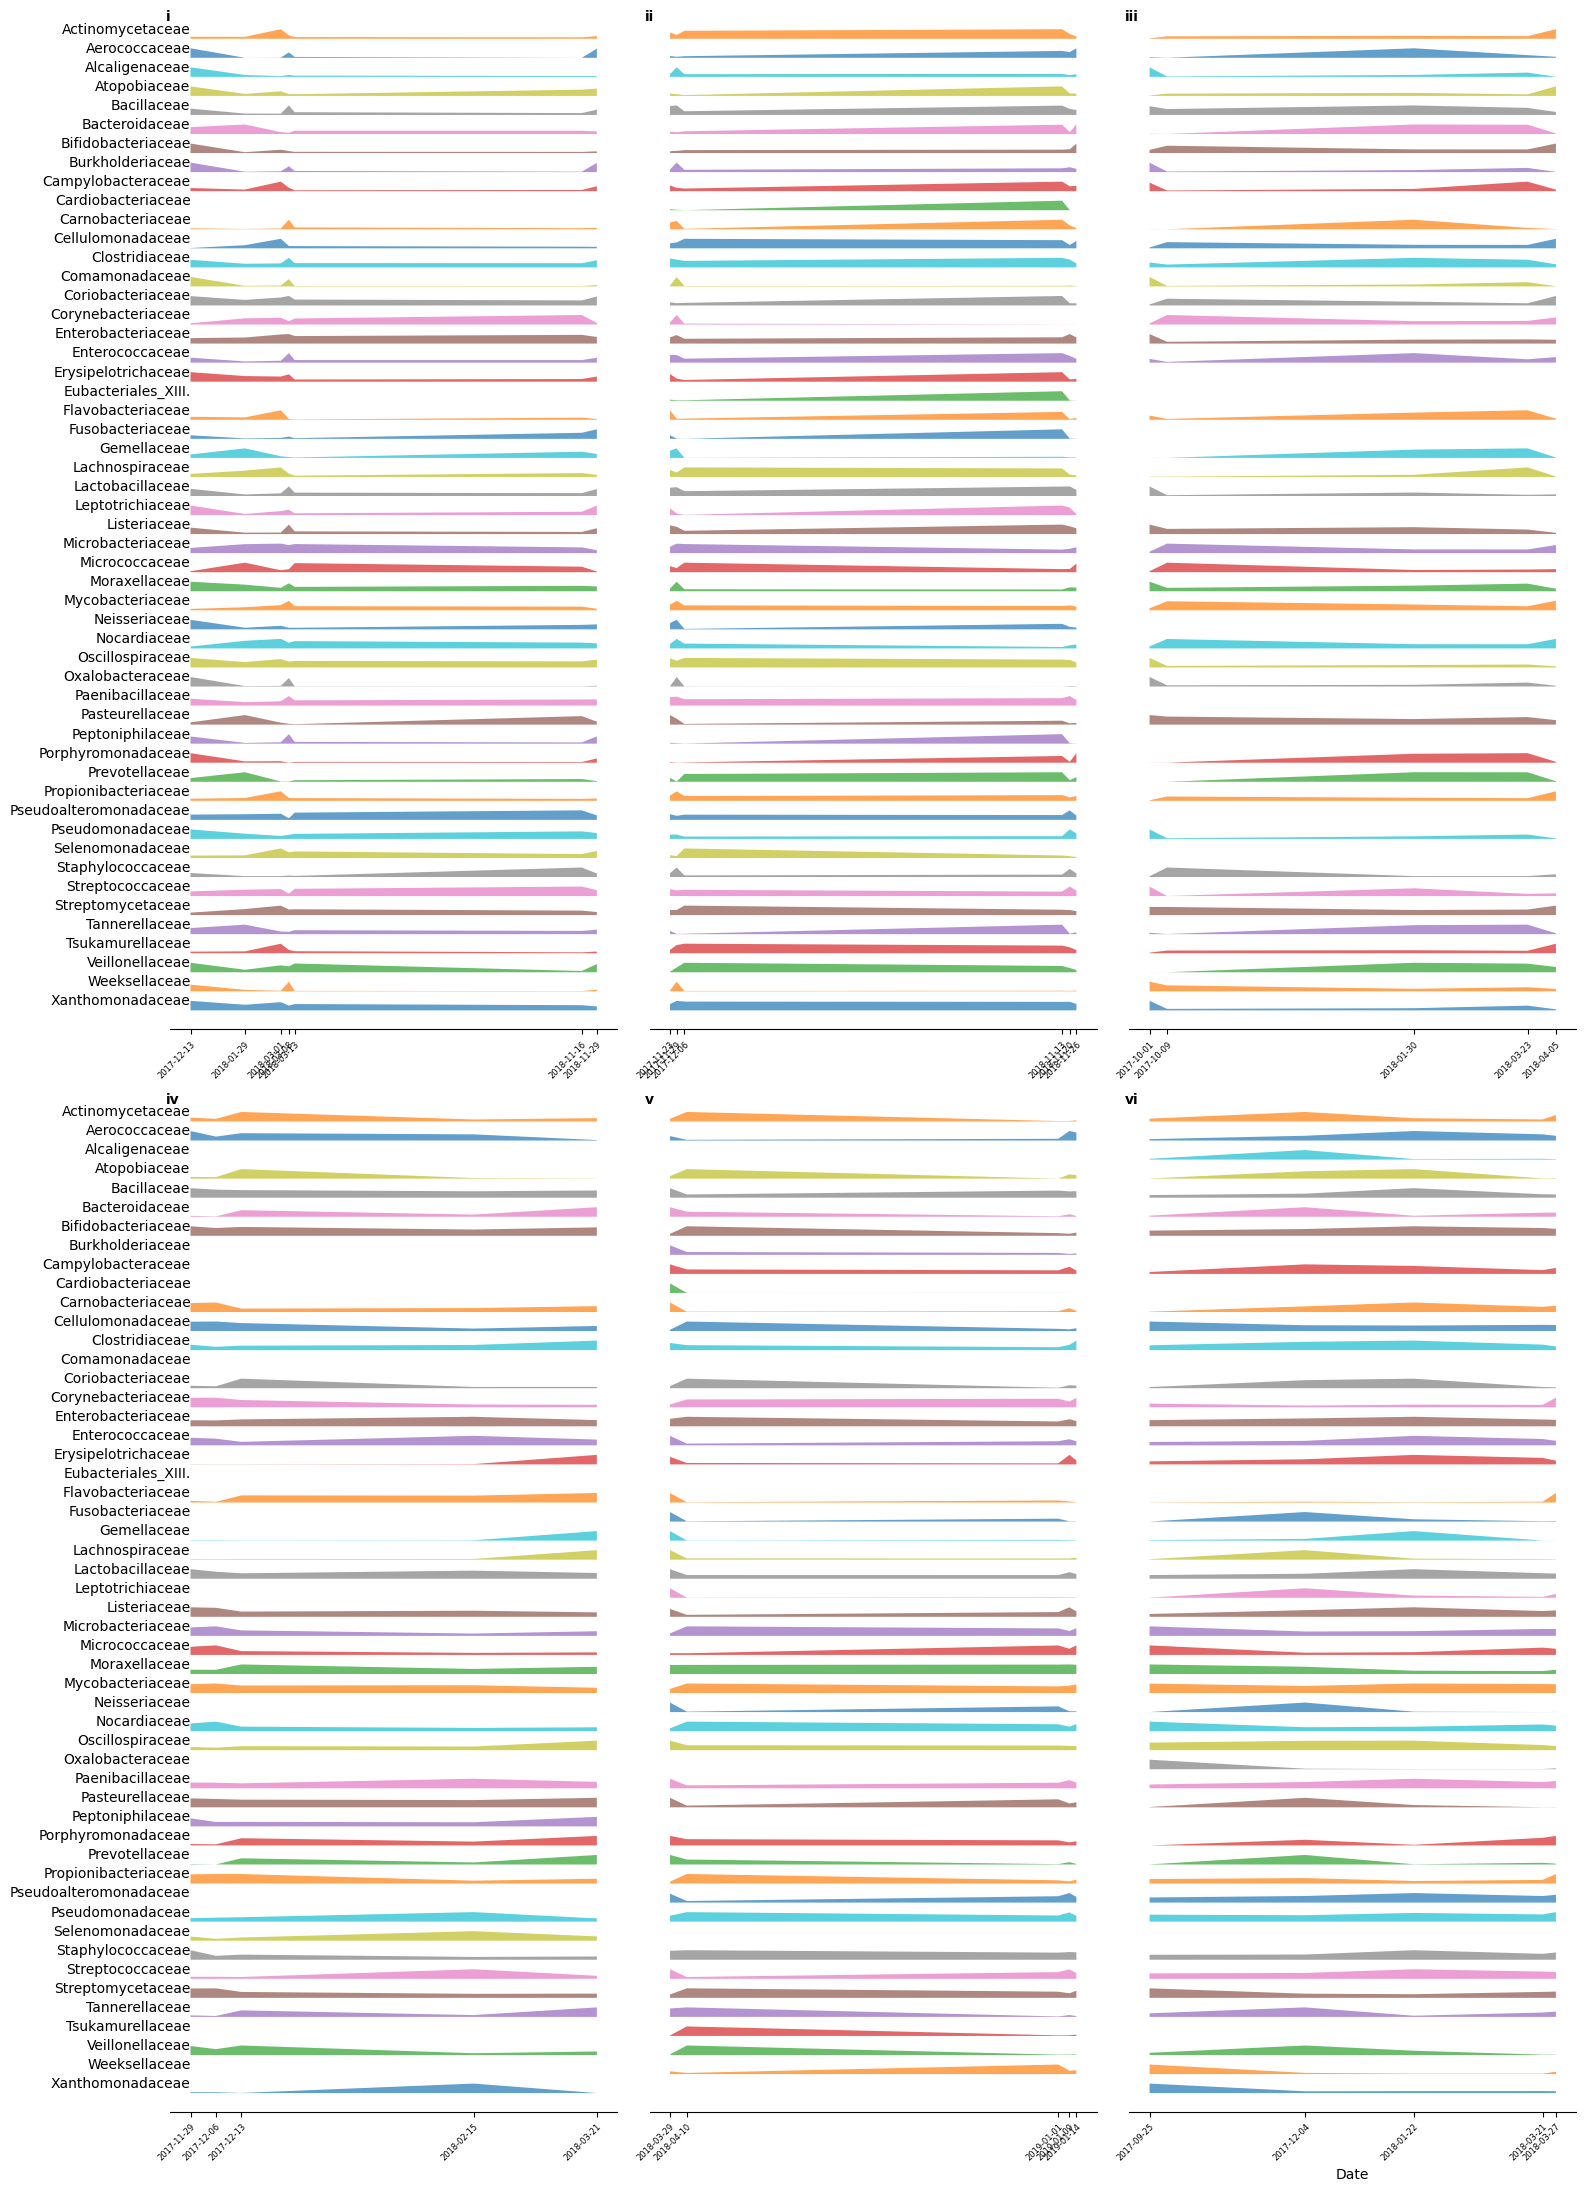

In [4]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 22), sharey=True)

# figure out the common bacteria that exceed minrowsum determined above
all_bacteria = dict()
minrowsum = 2500
for i, pwCF_ID in enumerate(interesting_people):
    pta = [x for x in tax_df.columns if x.startswith(pwCF_ID)]
    pta_df = tax_df[pta]
    pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]
    all_bacteria.update({x:x.replace(f"{taxa[0]}__", "").replace(" Family ", "_").replace("Candidatus ", "").split(" ")[0] for x in pta_df.index.unique()})
    
bacteria_name = dict(sorted(all_bacteria.items(), key=lambda item: item[1], reverse=True))
bacteria_list = list(bacteria_name.keys())

for i, pwCF_ID in enumerate(interesting_people):
    row, col = divmod(i, ncols)
    pta = [x for x in tax_df.columns if x.startswith(pwCF_ID)]
    pta_df = tax_df[pta]
    minrowsum = 1000
    pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]
    renames = {x: int(x.replace(f'{pwCF_ID}_', '').replace('_S', '')) for x in pta_df.columns}
    pta_df = pta_df.rename(columns=renames)

    # Ensure all bacteria in bacteria_list are present, fill missing with 0
    pta_df = pta_df.reindex(bacteria_list, fill_value=0)
    
    # Melt into long format
    df_long = pd.melt(
        pta_df.reset_index(names='taxonomy'),
        id_vars='taxonomy',
        var_name='Date',
        value_name='Value'
    )

    df_long['Date'] = pd.to_datetime(df_long['Date'], format='%Y%m%d')
    df_long['Date_Num'] = mdates.date2num(df_long['Date'])
    df_long

    

    ax = axes[row][col]

    # Define vertical spacing between ridges
    spacing = 2.0

    # Plot each bacteria's data
    for ix, bacteria in enumerate(bacteria_list):
        # Subset the data
        subset = df_long[df_long['taxonomy'] == bacteria]
        # Normalize values for consistent plotting
        values = subset['Value'] / subset['Value'].max()
        # Offset for the ridge
        offset = ix * spacing
        # Plot the ridge
        ax.fill_between(subset['Date'], offset, values + offset, alpha=0.7)
        # Add bacteria name
        if col == 0:
            ax.text(subset['Date'].min(), offset + spacing / 2, bacteria_name[bacteria], va='center', ha='right')

    # Adjust y-axis limits
    ax.set_ylim(-spacing, len(bacteria_list) * spacing)
    # Hide y-axis labels
    ax.set_yticks([])

    date_list = df_long['Date'].unique()
    # Set x-axis label
    plt.xlabel('Date')
    ax.set_xticks(date_list)
    plt.setp(ax.get_yticklabels(), fontsize=6)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
    """
    for j, label in enumerate(ax.get_xticklabels()):
        if j % 2 == 0:
            label.set_y(0)  # Position below x-axis
        else:
            label.set_visible(False)
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.title.set_text(f"pwCF {pwCF_ID}")  

    if i == 2:
        row = 1
        col = 0
    else:
        col += 1


# labels = [f"{chr(97+i)})" for i in range(nrows*ncols)] # this makes the labels a, b, c, d
labels = [cf_analysis_lib.int2roman(i+1) for i in range(nrows*ncols)] # this makes the labels roman numerals
for ax, label in zip(axes.flat, labels):
    ax.text(-0.01, 1.01, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label}) {ax.get_title()}", end="; ")
    ax.set_title("")
print()

# Adjust layout
plt.tight_layout()
fig.align_xlabels()
# Display the plot
plt.savefig('final_images/fig2a.png', dpi=300)
plt.savefig('final_images/fig2a.svg', dpi=300)
plt.show()

    

# Fig 2c.

What happens to the same people over time.

In [5]:
encoder_models = 'cluster_gbrfs'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPF', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPF'] = cluster_assignments['COPF'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

intcols = ['Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
pca = PCA(n_components=1)
md = metadata[intcols].dropna(subset=intcols)
md['Antibiotics_YN_enc'] = md['Antibiotics_YN'].astype('category').cat.codes
antibiotic_cols = ['Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
scaled = StandardScaler().fit_transform(md[antibiotic_cols])
tmp = pca.fit_transform(scaled)
md['Medications Score'] = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 100

metadata['Medications Score'] = metadata.index.map(md['Medications Score'])

# cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score_tokenised.tsv.gz'), compression='gzip', sep="\t", index_col=0)
print("Data Initiated!")

Data Initiated!



Progression of phase shifts in microbial communities. 
The same PCA ordination of all COPFs is shown for each pwCF. For each pwCF, highlighted points are coloured by whether they were seen as an 
out-patient (blue) or in-patient (red) in each panel. The arrows indicate the sampling progression in time.
The x (PC1) axis explains 36.3% of the variation 
and the y (PC2) axis explains 23.4% of the variation

The identifiers for the pwCF are

i 788707; ii 825012; iii 676138; iv 785991; v 748699; vi 658355; 


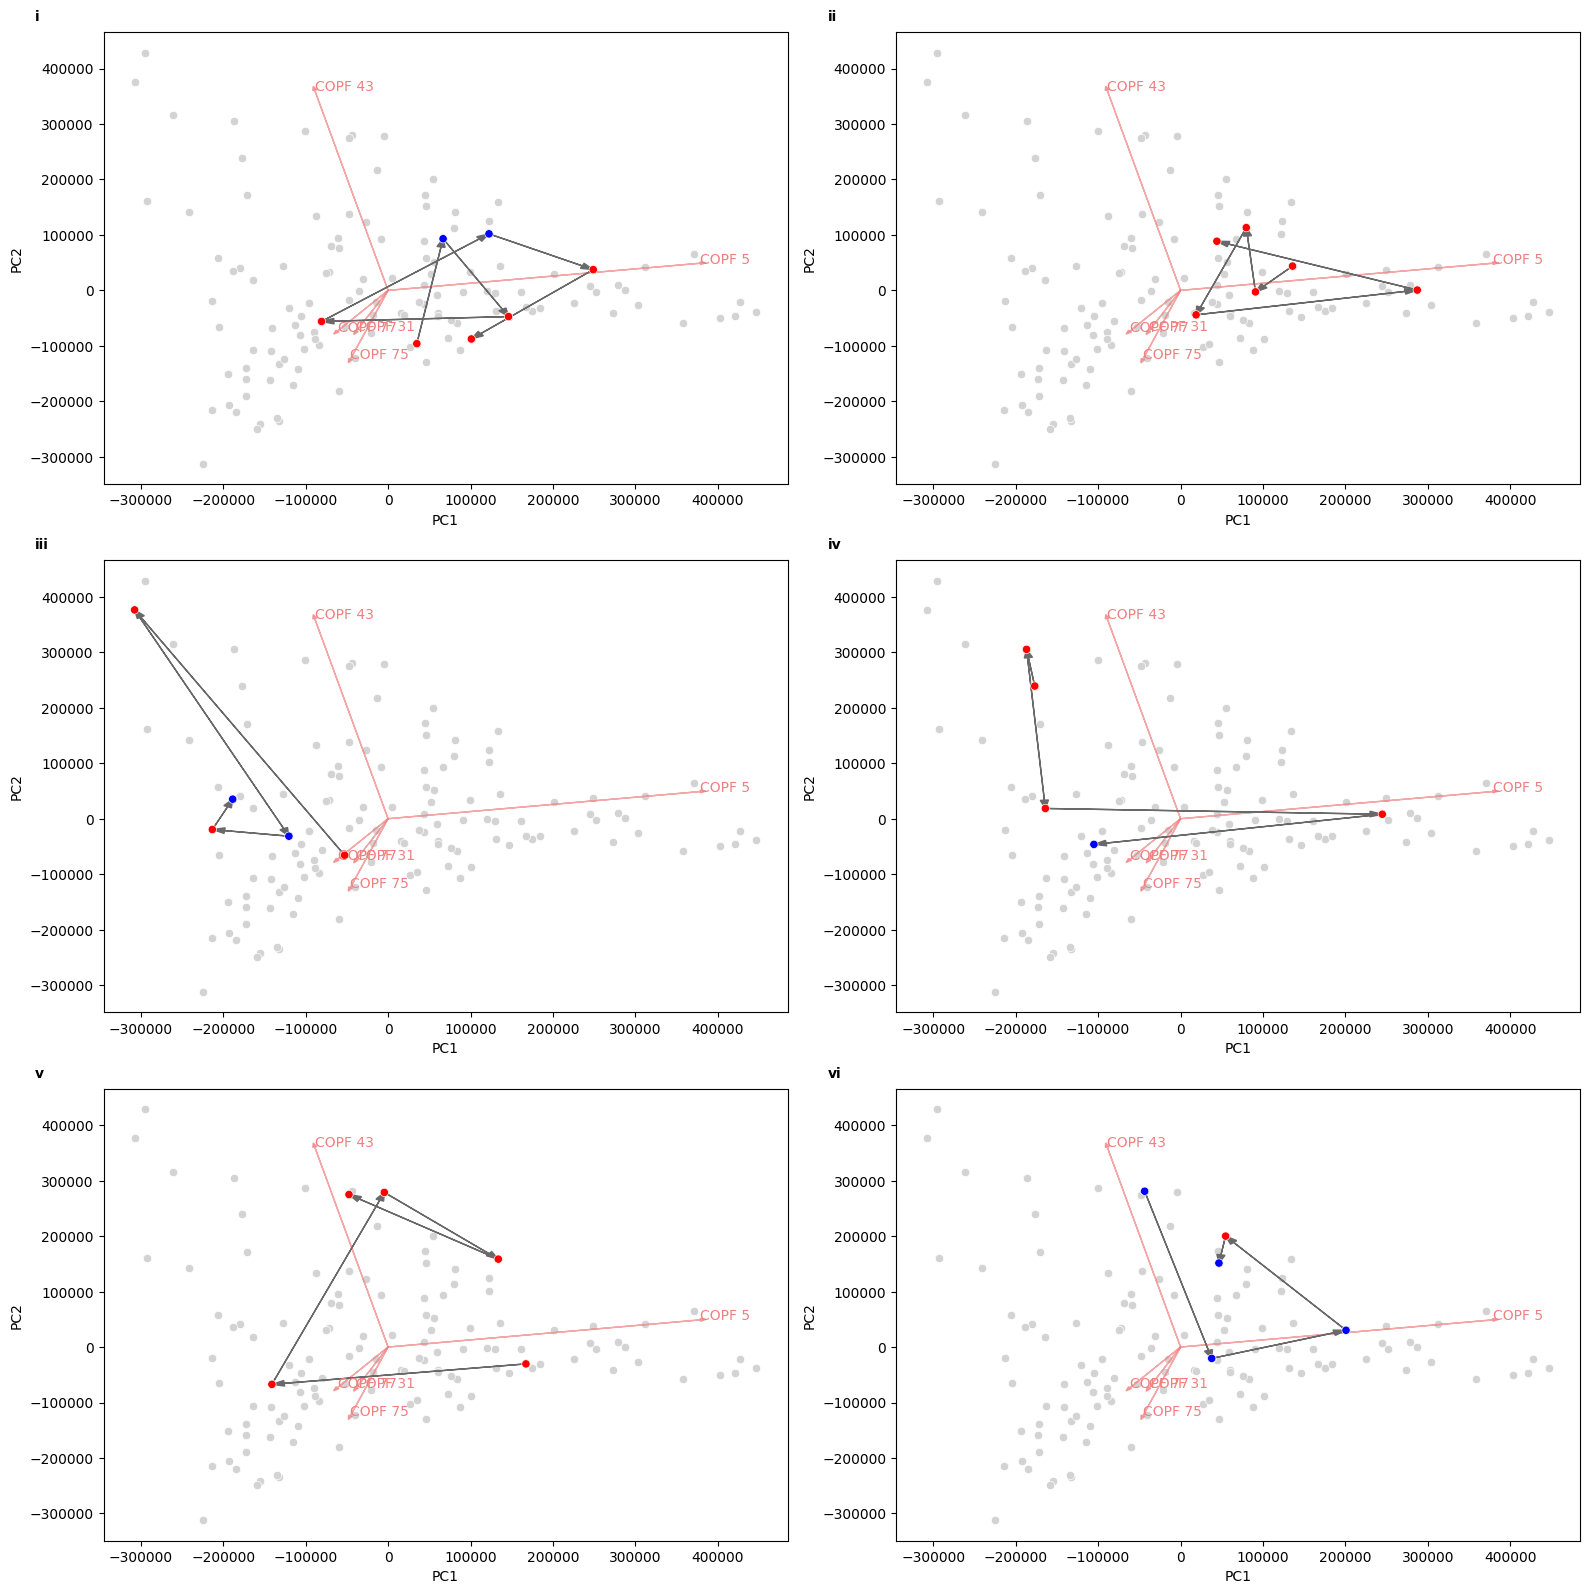

In [6]:

intcols = ['pwCF_ID', 'IP vs OP', 'FEV1/best FEV1', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs', 'Medications Score']
intcol = 'IP vs OP'
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols)
categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X)

# convert this pca into a dataframe so that we can get the components for each person.
pcaresult_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
pcaresult_df_id = pcaresult_df.join(metadata[['pwCF_ID', 'Sample date', intcol]])
loadings_df = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1', 'PC2', 'PC3', 'PC4'])
# find the topN loadings
topN = 5
loading_magnitude = np.sum(loadings_df**2, axis=1)
top_indices = loading_magnitude.sort_values(ascending=False).index[:topN]

pc1 = 'PC1'
pc2 = 'PC2'
cmap = sns.color_palette('coolwarm', as_cmap=True)

nrows, ncols = 3, 2
theme_colors = sns.color_palette("mako", len(interesting_people))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 16))
for ix, pwcf_id in enumerate(interesting_people):
    row, col = divmod(ix, ncols)
    ax = axes[row, col]
    mycolor = theme_colors[ix]
    
    # start with grey dots for everyone
    g = sns.scatterplot(data=pcaresult_df, x=pc1, y=pc2, c='lightgrey', ax=ax)
    # plot the loadings on top
    sep = 400000
    for i in top_indices:
        g.arrow(0, 0, loadings_df.loc[i, pc1]*sep, loadings_df.loc[i, pc2]*sep, color='lightcoral', alpha=0.7, head_width=5000)
        g.text(loadings_df.loc[i, pc1]*sep, loadings_df.loc[i, pc2]*sep, i, color='lightcoral', fontsize=10)
    
    # subset our one person
    sub = pcaresult_df_id[pcaresult_df_id['pwCF_ID'] == int(pwcf_id)]
    sub = sub.sort_values('Sample date')

    if len(metadata[intcol].unique()) == 2:
        grps = sorted(metadata[intcol].unique())
        if intcol == 'IP vs OP':
            grps = sorted(metadata[intcol].unique(), reverse=True)
        point_colours = ['b' if x in grps[0] else 'r' for x in sub[intcol]]
    else:
        point_colours = sub[intcol]

    
    # Draw arrows between consecutive points
    for i in range(len(sub) - 1):
        x_start, y_start = sub.iloc[i][[pc1, pc2]]
        x_end, y_end = sub.iloc[i+1][[pc1, pc2]]
        dx, dy = (x_end - x_start), (y_end - y_start)
        g.arrow(x_start, y_start, dx, dy, color='dimgrey', width=1, head_width=10000, length_includes_head=True)

    # Draw the points for this person
    g = sns.scatterplot(data=sub, x=pc1, y=pc2, c=point_colours, ax=ax)

    """
    if ix == 0:
        legend_elements = [
            mpatches.Patch(color='blue', label=grps[0]),
            mpatches.Patch(color='red', label=grps[1])
        ]
        ax.legend(handles=legend_elements)
    #g.legend().remove()
    """

print(f"""
Progression of phase shifts in microbial communities. 
The same PCA ordination of all COPFs is shown for each pwCF. For each pwCF, highlighted points are coloured by whether they were seen as an 
out-patient (blue) or in-patient (red) in each panel. The arrows indicate the sampling progression in time.
The x (PC1) axis explains {pca.explained_variance_ratio_[0]*100:.1f}% of the variation 
and the y (PC2) axis explains {pca.explained_variance_ratio_[1]*100:.1f}% of the variation

The identifiers for the pwCF are
""")

# labels = [f"{chr(97+i)})" for i in range(nrows*ncols)]
labels = [cf_analysis_lib.int2roman(i+1) for i in range(nrows*ncols)]
for i, (ax, label) in enumerate(zip(axes.flat, labels)):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {interesting_people[i]}", end="; ")
print()

plt.tight_layout()
plt.savefig('final_images/fig2b.png', dpi=300)
plt.savefig('final_images/fig2b.svg', dpi=300)
plt.show()
